In [ ]:
# Different layers
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, Input, Dense
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, Layer, Dropout
from tensorflow.keras.layers import GlobalAveragePooling1D, Conv1D
from tensorflow.keras.layers import Attention, AdditiveAttention
# For miscellaneous functions
from tensorflow import convert_to_tensor
from tensorflow.keras import utils
# Keras models
from tensorflow.keras import Model, Sequential
# For evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# For math/arrays
import numpy as np
# For plotting
import matplotlib.pyplot as plt
# For importing and processing HybrIK files
import os
import pickle
import scipy.optimize
# For train test split
# from sklearn.model_selection import train_test_split
# For imbalanced dataset
#! pip install imbalanced-learn
#from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad

## Data Preprocessing

In [ ]:
def extract_gait_cycle(feet_distances):
    '''
    To extract gait cycle according to the pattern of graph
    Output: a list of estimated start and end index for gait cycles
    '''
    y = feet_distances
    close_feet_count = 0
    cycle_start = 0

    if y[1] < y[0] :
        open_feet = False
        cycle_start = -1
    else:
        open_feet = True

    cycle_list = list()

    for i in range(1, len(feet_distances)):
        if y[i] < y[i-1] and open_feet:
            open_feet = False
        elif y[i] > y[i-1] and not open_feet:
            open_feet = True
            if cycle_start == -1:
                cycle_start = i
                continue

            close_feet_count = close_feet_count + 1
            if close_feet_count % 2 == 0:
                cycle_end = i - 1
                cycle_list.append((cycle_start, cycle_end))

                cycle_start = cycle_end

    return cycle_list

In [ ]:
def fit_sin(tt, yy):
    '''
    Use coordinates given to produce sine graph
    '''
    tt = np.array(tt)
    yy = np.array(yy)

    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

In [ ]:
def process_single_file (data, coord_pos) :
    '''
    data: all data from one single pickle file
    coord_pos: 0 for x coordinates, 1 for y coordinates, 2 for z coordinates
    '''
    LEFT_ANKLE = 7
    RIGHT_ANKLE = 8
    feet_distances = []
    gait_cycles = []

    # Get distance between left and right ankles as feet distance
    for i, frame in enumerate(data['pred_uvd']):
        LAnkle = frame[LEFT_ANKLE, coord_pos]
        RAnkle = frame[RIGHT_ANKLE, coord_pos]

        feet_distance = abs(LAnkle - RAnkle)
        feet_distances.append(feet_distance)

    # Fit the feet distances data into sine graph,
    # to remove outliers or inconsistent patterns
    x = np.array(range(0, len(feet_distances)))
    try:
        f = fit_sin(x, feet_distances)["fitfunc"]
        y = f(x)
        gait_cycles = extract_gait_cycle(y)
        #print(gait_cycles)
    except:
        # Fit the feet distances data into polynomial graph,
        # when it cannot fit into sine graph or no gait cycles found from sine graph
        if len(gait_cycles) <= 0:
            from scipy.interpolate import splrep, splev
            max_distance = max(feet_distances)
            smoothness = max_distance ** 2
            bspl = splrep(x,feet_distances,s=smoothness)
            y = splev(x,bspl)
            gait_cycles = extract_gait_cycle(y)
            #print(gait_cycles)

    return gait_cycles

In [ ]:
def extract_gait_information(file, data):
    '''
    Get gait start and end index lists according to the gait's view
    '''
    if 'front' in file.lower() or 'back' in file.lower():
        return process_single_file(data, 2)
    elif 'left' in file.lower() or 'right' in file.lower():
        return process_single_file(data, 0)

In [ ]:
def extract_data(input_file, max_length):
    '''
    Extract all samples and labels from the input file.
    Return any file not met maximum sequence length as error files
    '''
    all_samples = []
    all_labels = []
    error_files = []

    for file in os.listdir(input_file):

        # Process only HybrIK pickle files
        if not file.endswith('.pk'):
            continue

        # Extract features with shape (sample_size, frame_num, keypoints_num * xyz)
        file_path = os.path.join(input_file, file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        full_keypoints = data['pred_xyz_24_struct']
        #full_keypoints = data['pred_xyz_29']
        total_frames = len(full_keypoints)

        gait_cycles = extract_gait_information(file, data)
        mid_index = len(gait_cycles) // 2

        # Take middle gait cycles if possible
        start_index = gait_cycles[mid_index][0] if len(gait_cycles) > 0 else 0
        final_index = start_index + max_length - 1

        # If max sequence length is greater than total frames of files,
        # the file will not be used for processing
        if final_index >= total_frames:
            if max_length <= total_frames:
                start_index = 0
                final_index = max_length - 1
            else:
                error_files.append((file, total_frames))
                continue

        keypoints = []

        for i in range(start_index, final_index + 1) :
            keypoints.append(list(full_keypoints[i].flat))

        # Extract label
        # Check for gender
        if 'F' in file:
            gender = 1
        else:
            gender = 0

        # Check for age group
        from drive.MyDrive.model_preprocessing import process
        age = process(file)
        #age = int(file.split("_")[3])
        if age <= 0:
            continue
        elif age < 15:
            group = 0 # Child group
        elif age < 65:
            group = 1 # Adult group
        else:
            group = 2 # Senior group

        # Male child = 0
        # Female child = 1
        # Male adult = 2
        # Female adult = 3
        # Male senior = 4
        # Female senior = 5
        label = 2 * group + gender

        all_samples.append(keypoints)
        all_labels.append(label)

    return all_samples, all_labels, error_files

In [ ]:
# Locate dataset for train, validation and test set
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')
input_folder = "/content/drive/MyDrive"
test_folder = os.path.join(input_folder, "PK_test_set")
train_folder = os.path.join(input_folder, "PK_train_set")
validation_folder = os.path.join(input_folder, "PK_validation_set")

# Set sequence length
sequence_length = 60

# Retrieve dataset
all_error_files = []
X_train, y_train, error_files = extract_data(train_folder, sequence_length)
all_error_files.extend(error_files)
X_test, y_test, error_files = extract_data(test_folder, sequence_length)
all_error_files.extend(error_files)
X_val, y_val, error_files = extract_data(validation_folder, sequence_length)
all_error_files.extend(error_files)

# Print processing results
print("Train set:", len(X_train), "\nTest set:", len(X_test), "\nValidation set:", len(X_val))
if len(all_error_files) > 0:
    print("Error in processing files:")
    for file in all_error_files:
        print(f"\t- {file[0]} ({file[1]} frames)")

Mounted at /content/drive
Train set: 877 
Test set: 274 
Validation set: 219


In [ ]:
# Calculate number of output classes
n_classes = len(np.unique(y_train))

# Calculate dimension of vector that similar to embedding
num_coord = 24
xyz = 3
embed_dim = num_coord * xyz

# For balancing classes
#X_train_array = np.array(X_train)
#X_train_2d = X_train_array.reshape((X_train_array.shape[0], sequence_length * embed_dim))
#smote = SMOTE(random_state = 42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train_2d, y_train)
#X_train_3d = X_train_resampled.reshape((X_train_resampled.shape[0], sequence_length, embed_dim))

# Convert list to tensor
#X_train_tensor = convert_to_tensor(X_train_3d, dtype = np.float32)
X_train_tensor = convert_to_tensor(X_train, dtype = np.float32)
X_test_tensor = convert_to_tensor(X_test, dtype = np.float32)
X_val_tensor = convert_to_tensor(X_val, dtype = np.float32)

# Convert labels using one hot encoding
#y_train_categorical = utils.to_categorical(y_train_resampled)
y_train_categorical = utils.to_categorical(y_train)
y_test_categorical = utils.to_categorical(y_test)
y_val_categorical = utils.to_categorical(y_val)

# Print processing results
#print(len(X_train_tensor), len(X_test_tensor), len(y_train_resampled), len(y_test))
print(len(X_train_tensor), len(X_test_tensor), len(y_train), len(y_test))
print(X_train_tensor.shape)
print(n_classes)

877 274 877 274
(877, 60, 72)
6


In [ ]:
# Check frequency of each class in train dataset
label, counts = np.unique(y_train, return_counts=True)
#label, counts = np.unique(y_train_resampled, return_counts=True)
print(dict(zip(label, counts)))

{np.int64(0): np.int64(118), np.int64(1): np.int64(75), np.int64(2): np.int64(249), np.int64(3): np.int64(305), np.int64(4): np.int64(72), np.int64(5): np.int64(58)}


## Model Compilation

### Transformer Block

In [ ]:
class Config:
    def __init__(self):
        #self.vocab_size = 32000
        self.d_model = 72
        #self.n_layers = 2
        self.n_heads = 2
        self.d_kv_comp = 16
        self.d_rope = 16
        self.dropout = 0.4
        #self.n_experts = 32
        #self.n_shared = 2
        #self.top_k = 2
        self.seq_len = 60
        #self.batch_size = 8
        #self.ffn_dim = 384
        #self.device_groups = 4 # For device-limited routing

config = Config()

class RotaryEmbedding(tf.keras.Model):
    def __init__(self, dim, scale=40):
        super().__init__()
        assert dim % 2 == 0, "Dimension must be even for rotary embeddings"
        self.dim = dim
        self.inv_freq = 1.0 / (10000 ** (tf.range(0, dim // 2, 2, dtype=tf.float32) / (dim // 2)))
        self.scale = scale

    def call(self, seq_len):
        t = tf.range(seq_len, dtype=self.inv_freq.dtype) / self.scale
        freqs = tf.einsum("i,j->ij", t, self.inv_freq)
        return tf.concat([freqs, freqs], axis=-1)

def rotate_half(x):
    x1, x2 = tf.split(x, num_or_size_splits=2, axis=-1)
    return tf.concat([-x2, x1], axis=-1)

def apply_rotary(x, cos, sin):
    """
    Apply rotary embeddings to the first half of x.
    """
    # Split x into two parts: one for rotary embeddings and the other untouched
    x_rot, x_base = tf.split(x, num_or_size_splits=[tf.shape(cos)[-1], tf.shape(x)[-1] - tf.shape(cos)[-1]], axis=-1)
    # Apply rotary embeddings to the rotary part
    x_rot = (x_rot * cos) + (rotate_half(x_rot) * sin)
    # Concatenate the rotary-applied and base parts
    return tf.concat([x_rot, x_base], axis=-1)

class MemoryOptimizedMLA(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d_head = config.d_model // config.n_heads
        self.split_dim = self.d_head - config.d_rope

        # Projections
        self.W_dkv = tf.keras.layers.Dense(config.d_kv_comp, input_shape=(config.d_model,))
        self.W_dq = tf.keras.layers.Dense(config.d_kv_comp, input_shape=(config.d_model,))

        # Changed value projection to use d_head instead of split_dim
        self.W_uk = tf.keras.layers.Dense(config.n_heads * self.split_dim, input_shape=(config.d_kv_comp,))
        self.W_uv = tf.keras.layers.Dense(config.n_heads * self.d_head, input_shape=(config.d_kv_comp,))
        self.W_uq = tf.keras.layers.Dense(config.n_heads * self.split_dim, input_shape=(config.d_kv_comp,))

        self.W_qr = tf.keras.layers.Dense(config.n_heads * config.d_rope, input_shape=(config.d_kv_comp,))
        self.W_kr = tf.keras.layers.Dense(config.n_heads * config.d_rope, input_shape=(config.d_model,))

        self.rotary = RotaryEmbedding(config.d_rope)
        self.output_proj = tf.keras.layers.Dense(config.d_model, input_shape=(config.n_heads * self.d_head,))

        self.dropout = Dropout(config.dropout)

    def call(self, h, past_kv=None):
        batch_size, seq_len, _ = tf.shape(h)[0], tf.shape(h)[1], tf.shape(h)[-1]

        # KV Compression
        c_kv = self.W_dkv(h)
        k = tf.reshape(self.W_uk(c_kv), (batch_size, seq_len, config.n_heads, self.split_dim))
        v = tf.reshape(self.W_uv(c_kv), (batch_size, seq_len, config.n_heads, self.d_head))

        # Query Compression
        c_q = self.W_dq(h)
        q_base = tf.reshape(self.W_uq(c_q), (batch_size, seq_len, config.n_heads, self.split_dim))
        q_rot = tf.reshape(self.W_qr(c_q), (batch_size, seq_len, config.n_heads, config.d_rope))

        # Rotary embeddings with proper dimensions
        rotary_emb = self.rotary(seq_len)
        cos = tf.reshape(tf.cos(rotary_emb), (1, seq_len, 1, -1))  # [1, seq, 1, dim]
        sin = tf.reshape(tf.sin(rotary_emb), (1, seq_len, 1, -1))

        # Apply rotary embeddings
        q_rot = apply_rotary(q_rot, cos, sin)
        k_rot = apply_rotary(
            tf.reshape(self.W_kr(h), (batch_size, seq_len, config.n_heads, config.d_rope)),
            cos, sin
        )

        q = tf.concat([q_base, q_rot], axis=-1)
        k = tf.concat([k, k_rot], axis=-1)

        #q = q_base
        #k = k

        # Attention computation
        scores = tf.einsum("bqhd,bkhd->bhqk", q, k) / tf.sqrt(tf.cast(self.d_head, dtype=tf.float32))
        attn = tf.nn.softmax(scores, axis=-1)

        if config.dropout != 0:
            attn = self.dropout(attn)

        # Causal attention mask
        #attn_mask = tf.fill([seq_len, seq_len], float(0))
        #attn_mask = tf.linalg.set_diag(attn_mask, tf.ones([seq_len, seq_len]), k=(1-seq_len, 0))
        #attn_mask = tf.linalg.set_diag(attn_mask, tf.ones([seq_len]), k=0)  # masking upper triangular
        #attn_mask = tf.cast(attn_mask, dtype=tf.float32)
        #attn = tf.tensordot(attn, attn_mask, axes=1)

        out = tf.einsum("bhqk,bkhd->bqhd", attn, v)
        out = self.output_proj(tf.reshape(out, (batch_size, seq_len, config.d_model)))

        if config.dropout != 0:
            out = self.dropout(out)

        #return self.output_proj(tf.reshape(out, (batch_size, seq_len, -1))), (c_kv, k_rot)
        return out

In [ ]:
class EncoderLayer(Layer):
    def __init__(self, total_heads, total_dense_units, embed_dim):
        super(EncoderLayer, self).__init__()
        #self.attn = AdditiveAttention(use_scale = False)
        #self.attn = AdditiveAttention(use_scale = True)
        #self.attn = Attention(use_scale = False)
        self.attn1 = Attention(use_scale = True, dropout = 0.4)
        #self.attn2 = Attention(use_scale = True, dropout = 0.4)
        self.multihead = MemoryOptimizedMLA()
        #self.singlehead = MemoryOptimizedSLA()
        self.nnw = Sequential([Dense(total_dense_units, activation="relu"), Dense(embed_dim)]) # Feed forward network layer
        self.normalize_layer = LayerNormalization() # Normalization

    def call(self, inputs):
        attn_output = self.multihead(inputs)
        normalize_attn = self.normalize_layer(inputs + attn_output)
        #s_attn_output = self.singlehead(n_attn_output)
        attn_output = self.attn1([normalize_attn, normalize_attn])
        normalize_attn = self.normalize_layer(normalize_attn + attn_output)
        #attn_output = self.attn2([normalize_attn, normalize_attn])
        #normalize_attn = self.normalize_layer(normalize_attn + attn_output)
        nnw_output = self.nnw(normalize_attn)
        final_output = self.normalize_layer(normalize_attn + nnw_output)
        return final_output

### Mamba block

In [ ]:
from tensorflow.keras import initializers, regularizers, constraints

class RMSNorm(Layer):
    def __init__(self, epsilon=1e-7, gamma_initializer='ones', gamma_regularizer=None, gamma_constraint=None, **kwargs):
        super(RMSNorm, self).__init__(**kwargs)
        self.epsilon = epsilon
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        shape = (input_shape[-1],)
        self.gamma = self.add_weight(name='gamma',
                                     shape=shape,
                                     initializer=self.gamma_initializer,
                                     regularizer=self.gamma_regularizer,
                                     constraint=self.gamma_constraint,
                                     trainable=True)
        super(RMSNorm, self).build(input_shape)

    def call(self, inputs):
        rms = tf.sqrt(tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True) + self.epsilon)
        return self.gamma * inputs / rms

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
from dataclasses import dataclass
from typing import Union
from tensorflow import keras
import math
from tensorflow.keras import layers
from einops import rearrange, repeat

# Argument for MAMBA block configuration
@dataclass
class ModelArgs:
    model_input_dims: int = 64
    model_states: int = 64
    projection_expand_factor: int = 2
    conv_kernel_size: int = 4
    delta_t_min: float = 0.001
    delta_t_max: float = 0.1
    delta_t_scale: float = 0.1
    delta_t_init_floor: float = 1e-4
    conv_use_bias: bool = True
    dense_use_bias: bool = False
    layer_id: int = -1
    seq_length: int = 128
    use_lm_head: float = False

    def __post_init__(self):
        self.model_internal_dim: int = int(self.projection_expand_factor * self.model_input_dims)

        self.delta_t_rank = math.ceil(self.model_input_dims/16)
        if self.layer_id == -1:
            self.layer_id = np.round(np.random.randint(0, 1000), 4)

In [ ]:
def selective_scan(u, delta, A, B, C, D):
    # first step of A_bar = exp(ΔA), i.e., ΔA
    dA = tf.einsum('bld,dn->bldn', delta, A)
    dB_u = tf.einsum('bld,bld,bln->bldn', delta, u, B)

    dA_cumsum = tf.pad(
        dA[:, 1:], [[0, 0], [1, 1], [0, 0], [0, 0]])[:, 1:, :, :]

    dA_cumsum = tf.reverse(dA_cumsum, axis=[1])  # Flip along axis 1

    # Cumulative sum along all the input tokens, parallel prefix sum,
    # calculates dA for all the input tokens parallely
    dA_cumsum = tf.math.cumsum(dA_cumsum, axis=1)

    # second step of A_bar = exp(ΔA), i.e., exp(ΔA)
    dA_cumsum = tf.exp(dA_cumsum)
    dA_cumsum = tf.reverse(dA_cumsum, axis=[1])  # Flip back along axis 1

    x = dB_u * dA_cumsum
    # 1e-12 to avoid division by 0
    x = tf.math.cumsum(x, axis=1)/(dA_cumsum + 1e-12)

    y = tf.einsum('bldn,bln->bld', x, C)

    return y + u * D

In [ ]:
class MambaBlock(layers.Layer):
    def __init__(self, modelargs: ModelArgs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.args = modelargs
        args = modelargs
        self.layer_id = modelargs.layer_id

        self.in_projection = layers.Dense(
            args.model_internal_dim * 2,
            input_shape=(args.model_input_dims,), use_bias=False)

        self.conv1d = layers.Conv1D(
            filters=args.model_internal_dim,
            use_bias=args.conv_use_bias,
            kernel_size=args.conv_kernel_size,
            groups=args.model_internal_dim,
            data_format='channels_first',
            padding='causal'
        )

        # this layer takes in current token 'x'
        # and outputs the input-specific Δ, B, C (according to S6)
        self.x_projection = layers.Dense(args.delta_t_rank + args.model_states * 2, use_bias=False)

        # this layer projects Δ from delta_t_rank to the mamba internal
        # dimension
        self.delta_t_projection = layers.Dense(args.model_internal_dim,
                                               input_shape=(args.delta_t_rank,), use_bias=True)

        self.A = repeat(
                tf.range(1, args.model_states+1, dtype=tf.float32),
                'n -> d n', d=args.model_internal_dim)

        self.A_log = tf.Variable(
                tf.math.log(self.A),
                trainable=True, dtype=tf.float32,
                name=f"SSM_A_log_{args.layer_id}")

        self.D = tf.Variable(
                np.ones(args.model_internal_dim),
                trainable=True, dtype=tf.float32,
                name=f"SSM_D_{args.layer_id}")

        self.out_projection = layers.Dense(
                args.model_input_dims,
                input_shape=(args.model_internal_dim,),
                use_bias=args.dense_use_bias)

    def call(self, x):
        """Mamba block forward. This looks the same as Figure 3 in Section 3.4 in the Mamba pape.
        Official Implementation:
            class Mamba, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L119
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311
        """

        (batch_size, seq_len, dimension) = x.shape

        x_and_res = self.in_projection(x) # shape = (batch, seq_len, 2 * model_internal_dimension)
        (x, res) = tf.split(x_and_res,
                            [self.args.model_internal_dim,
                             self.args.model_internal_dim], axis=-1)

        x = rearrange(x, 'b l d_in -> b d_in l')
        x = self.conv1d(x)[:, :, :seq_len]
        x = rearrange(x, 'b d_in l -> b l d_in')

        x = tf.nn.swish(x)
        y = self.ssm(x)
        y = y * tf.nn.swish(res)
        return self.out_projection(y)

    def ssm(self, x):
        """Runs the SSM. See:
            - Algorithm 2 in Section 3.2 in the Mamba paper
            - run_SSM(A, B, C, u) in The Annotated S4
            Official Implementation:
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311
        """
        (d_in, n) = self.A_log.shape

        # Compute ∆ A B C D, the state space parameters.
        #     A, D are input independent (see Mamba paper [1] Section 3.5.2 "Interpretation of A" for why A isn't selective)
        #     ∆, B, C are input-dependent (this is a key difference between Mamba and the linear time invariant S4,
        #                                  and is why Mamba is called **selective** state spaces)

        A = -tf.exp(tf.cast(self.A_log, tf.float32)) # shape -> (d_in, n)
        D = tf.cast(self.D, tf.float32)

        x_dbl = self.x_projection(x) # shape -> (batch, seq_len, delta_t_rank + 2*n)

        (delta, B, C) = tf.split(
                x_dbl,
                num_or_size_splits=[self.args.delta_t_rank, n, n],
                axis=-1) # delta.shape -> (batch, seq_len) & B, C shape -> (batch, seq_len, n)

        delta = tf.nn.softplus(self.delta_t_projection(delta)) # shape -> (batch, seq_len, model_input_dim)

        return selective_scan(x, delta, A, B, C, D)

In [ ]:
class ResidualBlock(layers.Layer):
    def __init__(self, modelargs: ModelArgs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.args = modelargs
        self.mixer = MambaBlock(modelargs)
        #self.norm = LayerNormalization(epsilon=1e-5)
        self.norm = BatchNormalization(epsilon=1e-5)
        #self.norm = RMSNorm(epsilon=1e-5)

    def call(self, x):
        """
        Official Implementation:
            Block.forward(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L297

            Note: the official repo chains residual blocks that look like
                [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> ...
            where the first Add is a no-op. This is purely for performance reasons as this
            allows them to fuse the Add->Norm.

            We instead implement our blocks as the more familiar, simpler, and numerically equivalent
                [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> ....

        """
        return self.mixer(self.norm(x)) + x

### BioHashing

In [ ]:
class BioHashing(layers.Layer):
    def __init__(self, key = 0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        np.random.seed(key)
        self.M = np.random.rand(72, 72)
        self.M_orthonormal = self.gs(self.M)

    def gs_cofficient(self, v1, v2):
        return np.dot(v2, v1) / np.dot(v1, v1)

    def proj(self, v1, v2):
        return self.gs_cofficient(v1, v2) * v1

    def gs(self, X):
        # Gram-Schmidt process
        Y = np.zeros(shape=X.shape)
        for i in range(len(X)):
            temp_vec = X[i].astype(np.float64)
            for j in range(i) :
                proj_vec = self.proj(Y[j], X[i])
                temp_vec -= proj_vec

            Y[i] = temp_vec.astype(np.float64)

        # Normalisation process
        Y_norm = np.apply_along_axis(lambda x: x/np.sqrt(np.sum(np.square(x))), 1, Y)

        # Transpose of matrix
        Y_norm_T = Y_norm.T

        return Y_norm

    @tf.function
    def call(self, x):
        #def distort(ind):
        #    return tf.reshape(tf.matmul(tf.reshape(x[ind], [1, x[ind].shape[-1]]), M_orthonormal), [x[ind].shape[-1]])
        #x_hash = tf.map_fn(distort, range(tf.shape(x)[0]))
        #x_hash = list(map(lambda inX: np.dot(inX, M_orthonormal), x))
        x_hash = tf.matmul(x, self.M_orthonormal)
        return x_hash

### Model Compilation

In [ ]:
# Initiation for Transformer block
num_heads = 2
total_dense_units = 256

# Initiation for Mamba block
args = ModelArgs(
    model_input_dims=embed_dim,
    seq_length=sequence_length,
    #projection_expand_factor = 6,
)

# Setting seed for reproducibility
#np.random.seed(42)
#tf.random.set_seed(42)

# Start connecting the layers together
input_layer = Input(shape=(sequence_length, embed_dim))
mamba_layer_0 = ResidualBlock(args)(input_layer)
mamba_layer_1 = ResidualBlock(args)(mamba_layer_0)
dropout_layer_0 = Dropout(0.2)(mamba_layer_1)
mamba_layer_2 = ResidualBlock(args)(dropout_layer_0)
norm_layer_0 = BatchNormalization(epsilon = 1e-5)(mamba_layer_2)
attn_layer_0 = EncoderLayer(num_heads, total_dense_units, embed_dim)(norm_layer_0)
pool = GlobalAveragePooling1D()(attn_layer_0)
#biohash = BioHashing(key = 0)(pool)
d = Dense(total_dense_units, activation="relu")(pool)
dropout_layer_1 = Dropout(0.6)(d)
output_layer = Dense(n_classes, activation="softmax")(dropout_layer_1)

# Construct the model
model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy', 'Precision', 'Recall'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 72)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ (None, 60, 72)         │        52,128 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_4                │ (None, 60, 72)         │        52,128 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 72)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_5                │ (None, 60, 72)         │        52,128 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 60, 72)         │           288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_1 (EncoderLayer)  │ (None, 60, 72)         │        50,393 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 72)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,295 (887.87 KB)

 Trainable params: 226,719 (885.62 KB)

 Non-trainable params: 576 (2.25 KB)

## Model Training

In [ ]:
import time

start = time.time()
history = model.fit(
    X_train_tensor,
    y_train_categorical,
    batch_size=64,
    epochs=90,
    validation_data=(X_val_tensor, y_val_categorical),
    verbose = 2,
)

print("Time elapsed:", time.time() - start, "s")

Epoch 1/90
14/14 - 43s - 3s/step - Precision: 0.3548 - Recall: 0.0753 - accuracy: 0.2737 - loss: 1.7796 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4064 - val_loss: 1.5956
Epoch 2/90
14/14 - 2s - 156ms/step - Precision: 0.4558 - Recall: 0.0764 - accuracy: 0.3478 - loss: 1.6058 - val_Precision: 0.5000 - val_Recall: 0.0091 - val_accuracy: 0.3881 - val_loss: 1.6014
Epoch 3/90
14/14 - 2s - 153ms/step - Precision: 0.4955 - Recall: 0.1243 - accuracy: 0.3968 - loss: 1.4971 - val_Precision: 0.5000 - val_Recall: 0.0091 - val_accuracy: 0.4018 - val_loss: 1.5866
Epoch 4/90
14/14 - 3s - 184ms/step - Precision: 0.5869 - Recall: 0.1733 - accuracy: 0.4515 - loss: 1.3914 - val_Precision: 0.3920 - val_Recall: 0.3562 - val_accuracy: 0.4064 - val_loss: 1.6958
Epoch 5/90
14/14 - 3s - 179ms/step - Precision: 0.5656 - Recall: 0.2509 - accuracy: 0.4732 - loss: 1.3303 - val_Precision: 0.4101 - val_Recall: 0.2603 - val_accuracy: 0.3836 - val_loss: 1.7423
Epoch 6/90
14/14 - 3s - 201ms

## Model Evaluation

In [ ]:
print(history.history.keys())

dict_keys(['Precision', 'Recall', 'accuracy', 'loss', 'val_Precision', 'val_Recall', 'val_accuracy', 'val_loss'])


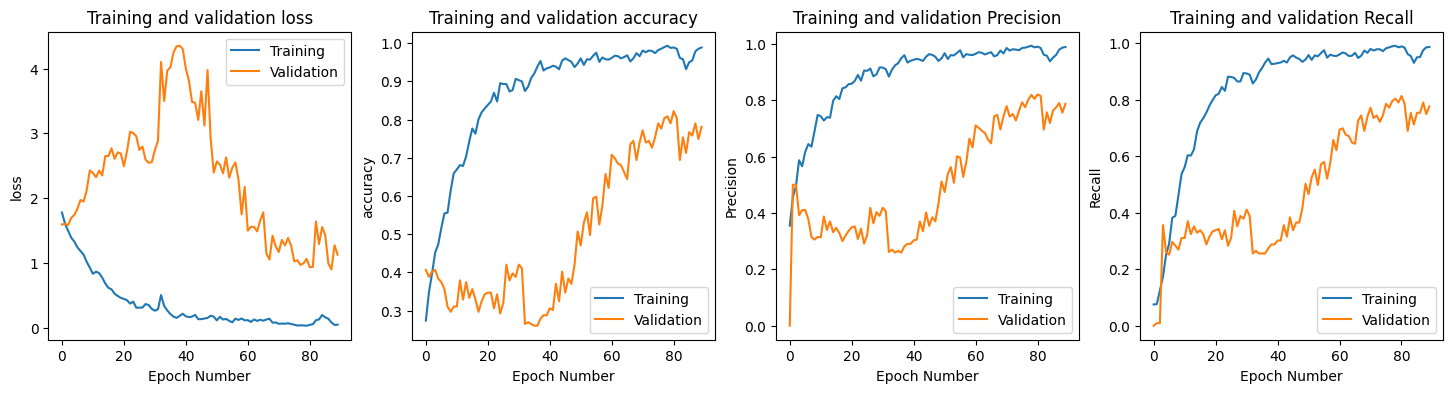

In [ ]:
fig = plt.figure(figsize=(18,4))
metric = ['loss', 'accuracy', 'Precision', 'Recall']
validation_metric = ['val_loss', 'val_accuracy', 'val_Precision', 'val_Recall']

for i,j,k in zip(metric, validation_metric, np.arange(len(metric))):
    fig.add_subplot(141+k)

    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.legend(['Training', 'Validation'])
    plt.title('Training and validation ' + i)
    plt.xlabel('Epoch Number')
    plt.ylabel(i)

plt.show()

Loss: 1.4051127433776855
Accuracy: 77.01%
Precision: 77.57%
Recall: 77.01%
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 492ms/step


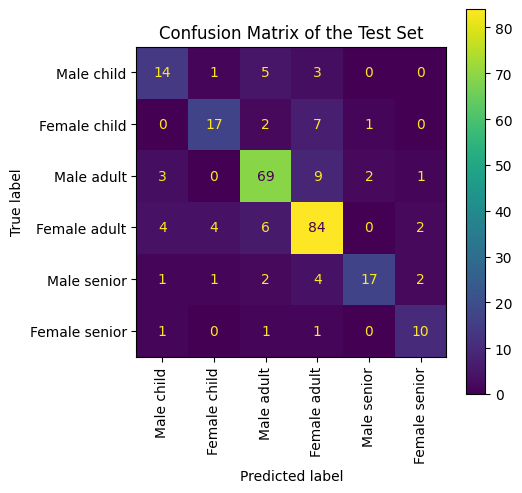

               precision    recall  f1-score   support

   Male child       0.61      0.61      0.61        23
 Female child       0.74      0.63      0.68        27
   Male adult       0.81      0.82      0.82        84
 Female adult       0.78      0.84      0.81       100
  Male senior       0.85      0.63      0.72        27
Female senior       0.67      0.77      0.71        13

     accuracy                           0.77       274
    macro avg       0.74      0.72      0.73       274
 weighted avg       0.77      0.77      0.77       274

Correct classification:  211 / 274


In [ ]:
scores = model.evaluate(X_test_tensor, y_test_categorical, verbose = 0)
print("Loss:", scores[0])
print("Accuracy: %.2f%%" % (scores[1] * 100))
print("Precision: %.2f%%" % (scores[2] * 100))
print("Recall: %.2f%%" % (scores[3] * 100))

# For confusion matrix
test_predict = model.predict(X_test_tensor)
test_predict_labels = np.argmax(test_predict, axis=1)

fig, ax = plt.subplots(figsize=(5, 5))

# Create and display the confusion matrix
label_list = ["Male child", "Female child", "Male adult", "Female adult", "Male senior", "Female senior"]
test_confusion_matrix = confusion_matrix(y_test, test_predict_labels)
cm = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix,
display_labels=label_list)
cm.plot(xticks_rotation="vertical", ax=ax)
plt.title('Confusion Matrix of the Test Set')
plt.show()
print(classification_report(y_test, test_predict_labels, target_names=label_list))
print('Correct classification: ', np.sum(np.diagonal(test_confusion_matrix)), '/', len(test_predict_labels))